**Transfomer Layers Calculation**

In [ ]:
def calculate_vit_flops_and_memory(
    image_size, patch_size, num_input_channels, embedding_dim, num_heads, feedforward_dim, output_dim
):
    """
    Calculate the FLOPs, memory accesses, and operation intensity (OI) for a Vision Transformer (ViT).

    Args:
        image_size (int): Size of the input image (assume square image of dimensions image_size x image_size).
        patch_size (int): Size of each patch (assume square patch of dimensions patch_size x patch_size).
        num_input_channels (int): Number of input channels (e.g., 3 for RGB images).
        embedding_dim (int): Dimension of the embeddings.
        num_heads (int): Number of attention heads.
        feedforward_dim (int): Dimension of the feedforward network.
        num_layers (int): Number of transformer layers.
        output_dim (int): Output dimension (e.g., number of classes).

    Returns:
        tuple: Two arrays - one for FLOPs and one for Operation Intensities (OI).
    """
    # Constants for bytes per element (assuming FP32)
    BYTES_PER_ELEMENT = 4

    # Calculate the number of patches
    num_patches = (image_size // patch_size) ** 2

    # FLOPs for embedding patches into the embedding dimension (projection layer)
    flops_patch_embedding = 2 * num_patches * (patch_size**2 * num_input_channels) * embedding_dim + embedding_dim * num_patches

    # Memory accesses for patch embedding
    memory_patch_embedding = num_patches * (patch_size**2 * num_input_channels + embedding_dim)

    # FLOPs for Multi-Head Self-Attention (MHSA) per layer
    flops_mhsa = (
        (2 * 3 * num_patches * embedding_dim**2 + num_patches * embedding_dim +  # Query, Key, Value projections
         2 * num_patches**2 * embedding_dim +  # Attention score computation
         2 * num_patches**2 * embedding_dim +  # Attention-weighted sum
         2 * num_patches * embedding_dim**2)  # Output projection
    )

    # Memory accesses for MHSA
    memory_mhsa = (
        num_patches * embedding_dim * 3 + num_patches * embedding_dim +  # Query, Key, Value reads
        num_patches**2 * num_heads +  # Attention scores
        num_patches * embedding_dim  # Output writes
    )

    # FLOPs for Feed-Forward Network (FFN) per layer
    flops_ffn = 4 * num_patches * embedding_dim * feedforward_dim + feedforward_dim * num_patches + embedding_dim * num_patches

    # Memory accesses for FFN
    memory_ffn = num_patches * embedding_dim + 2 * embedding_dim * feedforward_dim + num_patches * embedding_dim + num_patches * feedforward_dim + num_patches * embedding_dim

    # FLOPs for the final classification head (Linear Layer)
    flops_linear = 2 * embedding_dim * output_dim + output_dim

    # Memory accesses for classification head
    memory_linear = output_dim * embedding_dim + output_dim

    # Calculate Operation Intensity (OI) for individual components
    oi_patch = flops_patch_embedding / (memory_patch_embedding * BYTES_PER_ELEMENT) if memory_patch_embedding != 0 else 0
    oi_mhsa = flops_mhsa / (memory_mhsa * BYTES_PER_ELEMENT) if memory_mhsa != 0 else 0
    oi_ffn = flops_ffn / (memory_ffn * BYTES_PER_ELEMENT) if memory_ffn != 0 else 0
    oi_linear = flops_linear / (memory_linear * BYTES_PER_ELEMENT) if memory_linear != 0 else 0

    # Return FLOPs and OI as arrays
    return [flops_patch_embedding, flops_mhsa, flops_ffn, flops_linear], [oi_patch, oi_mhsa, oi_ffn, oi_linear]


def main():
    print("Vision Transformer (ViT) FLOPs and Operation Intensity Calculator\n")

    # Example Parameters for ViT
    image_size = 32         # Input image size (e.g., 224x224 for ViT-Base)
    patch_size = 4          # Patch size (e.g., 16x16 patches)
    num_input_channels = 3   # Input channels (e.g., RGB image)
    embedding_dim = 16      # Embedding dimension
    num_heads = 4           # Number of attention heads
    feedforward_dim = 32    # Feedforward network dimension
    output_dim = 10         # Output dimension (e.g., 1000 classes for classification)

    # Calculate FLOPs and OI values
    flops, oi_values = calculate_vit_flops_and_memory(
        image_size, patch_size, num_input_channels, embedding_dim, num_heads, feedforward_dim, output_dim
    )

    # Print FLOPs
    print("FLOPs Breakdown:")
    print(f"Patch Embedding FLOPs: {flops[0]:,}")
    print(f"MHSA Layer FLOPs: {flops[1]:,}")
    print(f"FFN Layer FLOPs: {flops[2]:,}")
    print(f"Classification Head FLOPs: {flops[3]:,}")

    # Print OI values
    print("\nOperation Intensities:")
    print(f"Patch Embedding Layer OI: {oi_values[0]:.4f}")
    print(f"MHSA Layer OI: {oi_values[1]:.4f}")
    print(f"FFN Layer OI: {oi_values[2]:.4f}")
    print(f"Classification Head OI: {oi_values[3]:.4f}")
    print(f"CI per layer: {flops}")
    print(f"OI per layer: {oi_values}")

if __name__ == "__main__":
    main()


Vision Transformer (ViT) FLOPs and Operation Intensity Calculator

FLOPs Breakdown:
Patch Embedding FLOPs: 99,328
MHSA Layer FLOPs: 394,240
FFN Layer FLOPs: 134,144
Classification Head FLOPs: 330

Operation Intensities:
Patch Embedding Layer OI: 6.0625
MHSA Layer OI: 4.5833
FFN Layer OI: 5.4583
Classification Head OI: 0.4853
CI per layer: [99328, 394240, 134144, 330]
OI per layer: [6.0625, 4.583333333333333, 5.458333333333333, 0.4852941176470588]


**DNN Layers Calculation**

In [ ]:
def calculate_layer_info(layer, input_rows, input_cols, output_rows, output_cols, kernel_size, input_channels, output_channels):
    """
    Calculate and return the details for a given layer.

    Args:
        layer (int): Layer number
        input_rows (int): Number of input rows
        input_cols (int): Number of input columns
        output_rows (int): Number of output rows
        output_cols (int): Number of output columns
        kernel_size (int): Kernel size
        input_channels (int): Number of input channels
        output_channels (int): Number of output channels

    Returns:
        dict: Dictionary containing layer details and Computational Intensity (CI) and Operational Intensity (OI).
    """
    BYTES_PER_ELEMENT = 4
    # Calculate MACs for the layer
    macs = (
        kernel_size
        * input_channels
        * output_rows
        * output_cols
        * output_channels
    )

    # Calculate computational intensity
    computational_intensity = macs * 2

    # Calculate memory access
    memory_access = (
        (input_rows * input_cols * input_channels)
        + (output_rows * output_cols * output_channels)
        + (kernel_size * input_channels * output_channels)
    )

    # Calculate Operational Intensity, rounded to 2 decimal places
    OI = round(computational_intensity / (memory_access * BYTES_PER_ELEMENT), 2)  # Assume 4 bytes per element

    # Return the layer details
    return {
        "Layer": layer,
        "Computational Intensity": computational_intensity,
        "Operational Intensity": OI,
    }


def main():
    print("Deep Neural Network Layer Information Collector")

    # Example usage: Define layer parameters directly
    layers_input = [
        # layer, input_rows, input_cols, output_rows, output_cols, kernel_size, input_channels, output_channels
        (1, 224, 224, 55, 55, 121, 3, 96),
        (2, 27, 27, 27, 27, 25, 96, 256),
        (3, 13, 13, 13, 13, 9, 256, 384),
        (4, 13, 13, 13, 13, 9, 384, 384),
        (5, 13, 13, 13, 13, 9, 384, 256),
        (6, 9216, 1, 4096, 1, 1, 9216, 1),
        (7, 4096, 1, 4096, 1, 1, 4096, 1),
        (8, 4096, 1, 1000, 1, 1, 4096, 1),
    ]

    # Collect Operational Intensity and Computational Intensity values for all layers
    OI_values = []
    CI_values = []
    for layer in layers_input:
        layer_info = calculate_layer_info(*layer)
        OI_values.append(layer_info["Operational Intensity"])
        CI_values.append(layer_info["Computational Intensity"])

    print("\nOperational Intensity (OI) for All Layers:")
    for i, oi in enumerate(OI_values, start=1):
        print(f"Layer {i}: OI = {oi:.2f}")

    print("\nComputational Intensity (CI) for All Layers:")
    for i, ci in enumerate(CI_values, start=1):
        print(f"Layer {i}: CI = {ci:,}")

    return OI_values, CI_values


if __name__ == "__main__":
    oi_array, ci_array = main()
    print("CI Array:", ci_array)
    print("OI Array:", oi_array)



Deep Neural Network Layer Information Collector

Operational Intensity (OI) for All Layers:
Layer 1: OI = 110.78
Layer 2: OI = 257.11
Layer 3: OI = 75.30
Layer 4: OI = 76.97
Layer 5: OI = 75.30
Layer 6: OI = 0.22
Layer 7: OI = 0.50
Layer 8: OI = 0.12

Computational Intensity (CI) for All Layers:
Layer 1: CI = 210,830,400
Layer 2: CI = 895,795,200
Layer 3: CI = 299,040,768
Layer 4: CI = 448,561,152
Layer 5: CI = 299,040,768
Layer 6: CI = 75,497,472
Layer 7: CI = 33,554,432
Layer 8: CI = 8,192,000
CI Array: [210830400, 895795200, 299040768, 448561152, 299040768, 75497472, 33554432, 8192000]
OI Array: [110.78, 257.11, 75.3, 76.97, 75.3, 0.22, 0.5, 0.12]


PLOTTING ANALYSIS

Floorline Plot

Archicture: Dig
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 0.729%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 0.311%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 1.063%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 1.040%
Layer 5 : E_Difference (E_layer - E_dec_lower_bound) = 1.064%
Layer 6 : E_Difference (E_layer - E_dec_lower_bound) = 160.000%
Layer 7 : E_Difference (E_layer - E_dec_lower_bound) = 160.000%
Layer 8 : E_Difference (E_layer - E_dec_lower_bound) = 160.000%


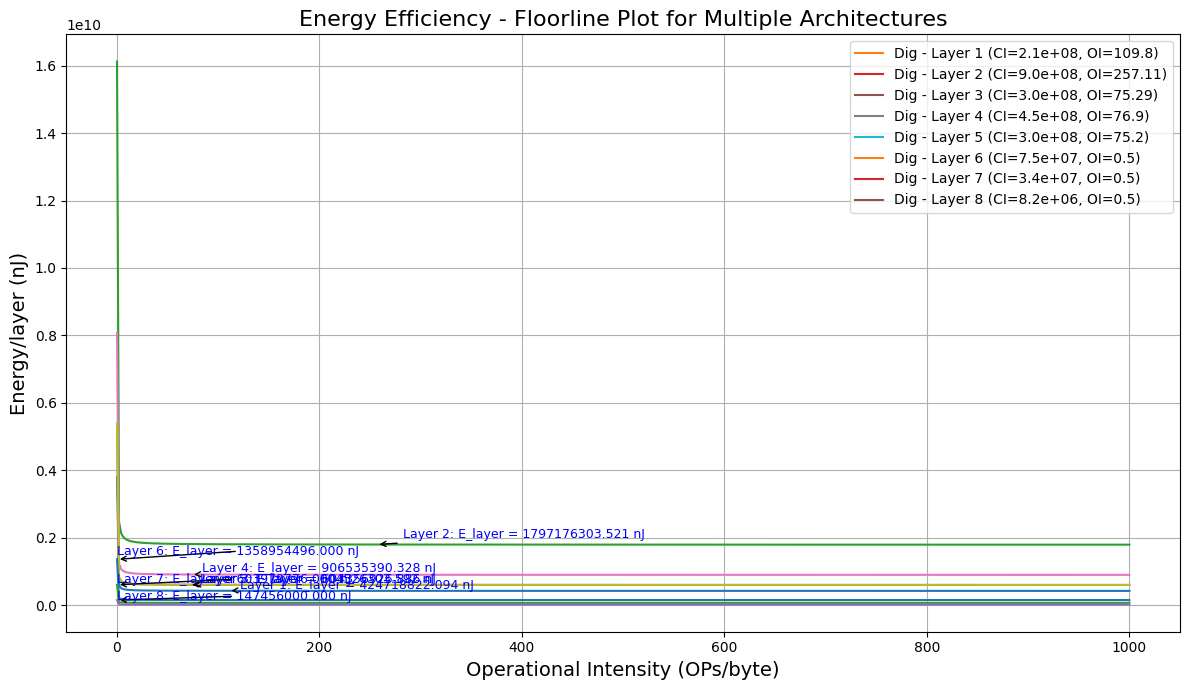

Archicture: PIM
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 0.007%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 0.003%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 0.010%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 0.010%
Layer 5 : E_Difference (E_layer - E_dec_lower_bound) = 0.010%
Layer 6 : E_Difference (E_layer - E_dec_lower_bound) = 1.500%
Layer 7 : E_Difference (E_layer - E_dec_lower_bound) = 1.500%
Layer 8 : E_Difference (E_layer - E_dec_lower_bound) = 1.500%


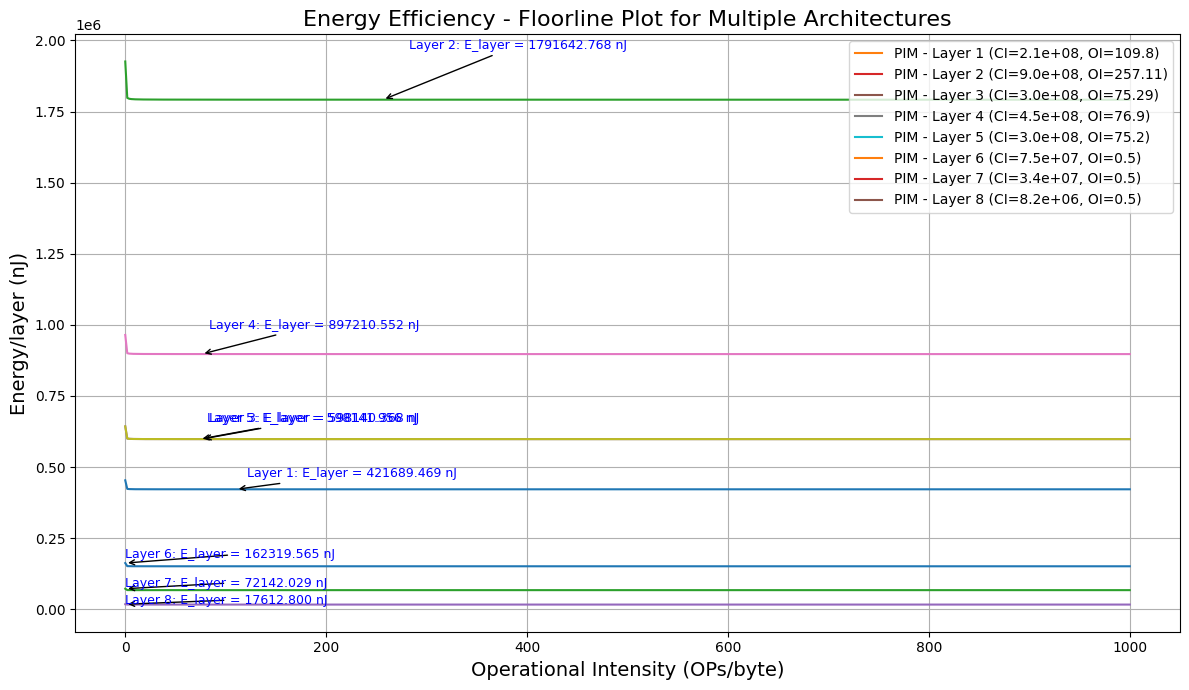

Archicture: PNM
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 0.068%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 0.029%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 0.100%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 0.098%
Layer 5 : E_Difference (E_layer - E_dec_lower_bound) = 0.100%
Layer 6 : E_Difference (E_layer - E_dec_lower_bound) = 15.000%
Layer 7 : E_Difference (E_layer - E_dec_lower_bound) = 15.000%
Layer 8 : E_Difference (E_layer - E_dec_lower_bound) = 15.000%


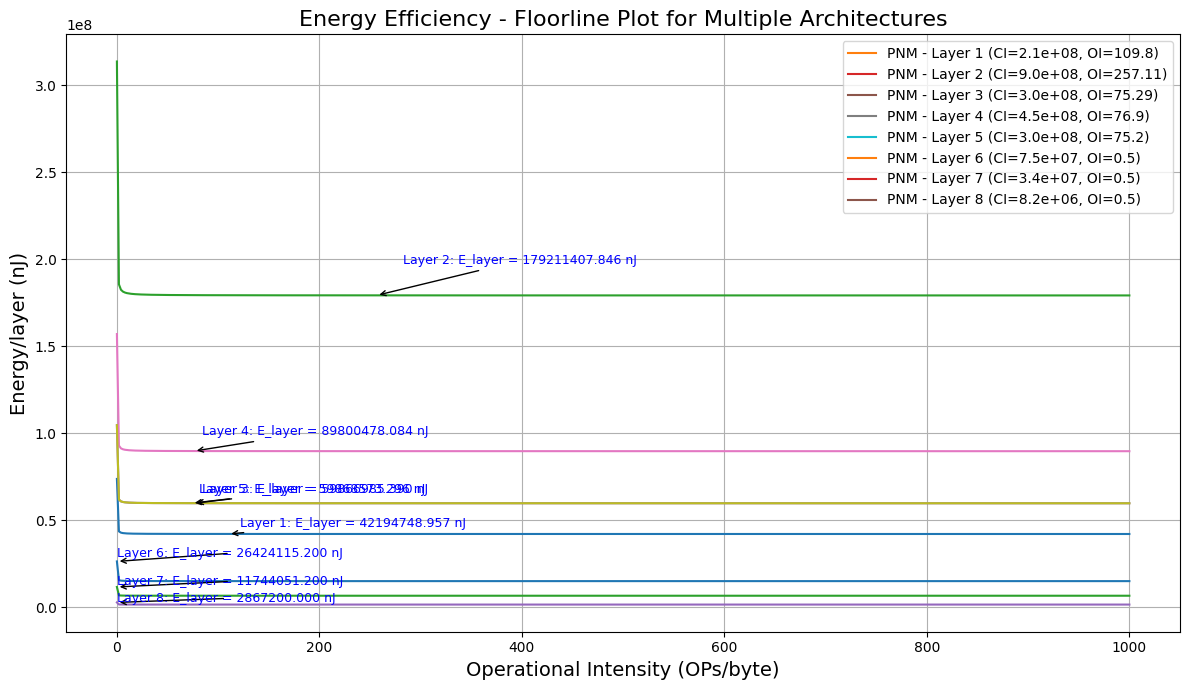

Archicture: Dig
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 13.196%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 17.455%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 14.656%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 164.848%


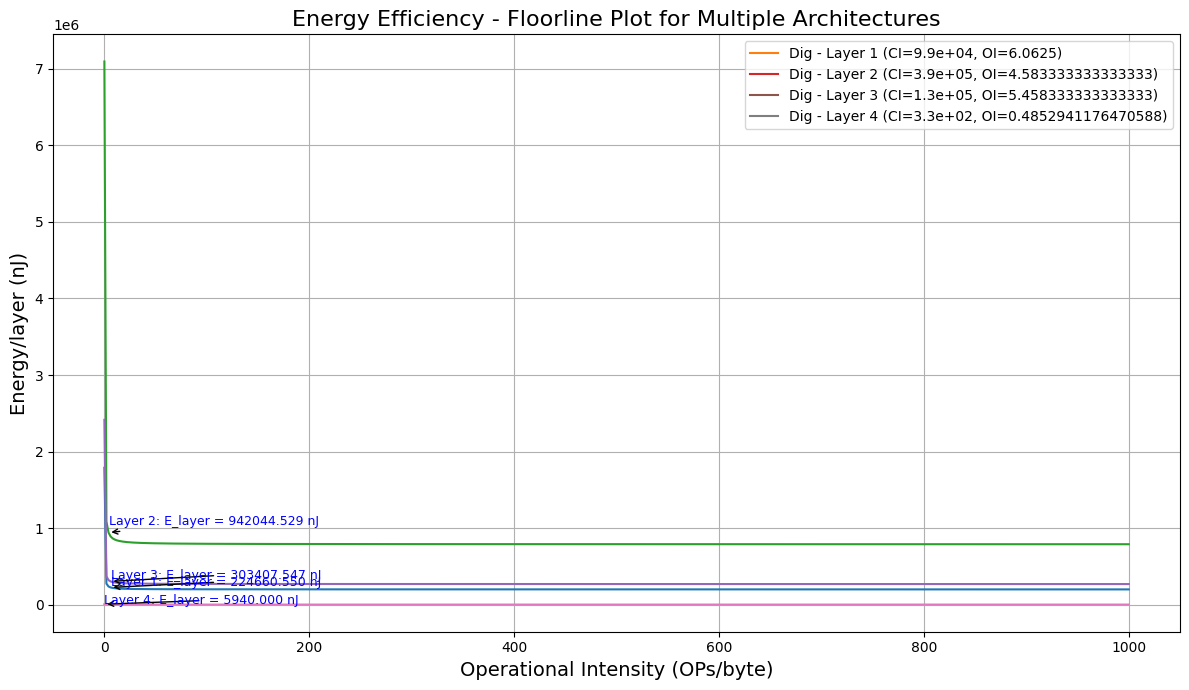

Archicture: PIM
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 0.124%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 0.164%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 0.137%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 1.545%


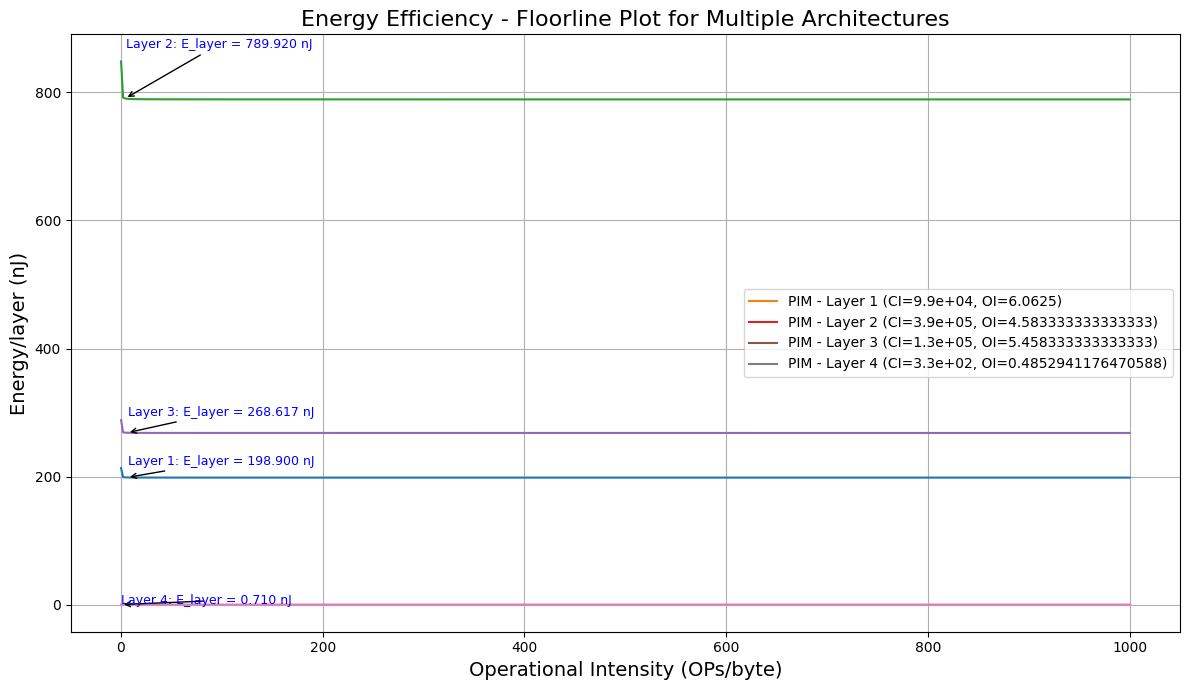

Archicture: PNM
Layer 1 : E_Difference (E_layer - E_dec_lower_bound) = 1.237%
Layer 2 : E_Difference (E_layer - E_dec_lower_bound) = 1.636%
Layer 3 : E_Difference (E_layer - E_dec_lower_bound) = 1.374%
Layer 4 : E_Difference (E_layer - E_dec_lower_bound) = 15.455%


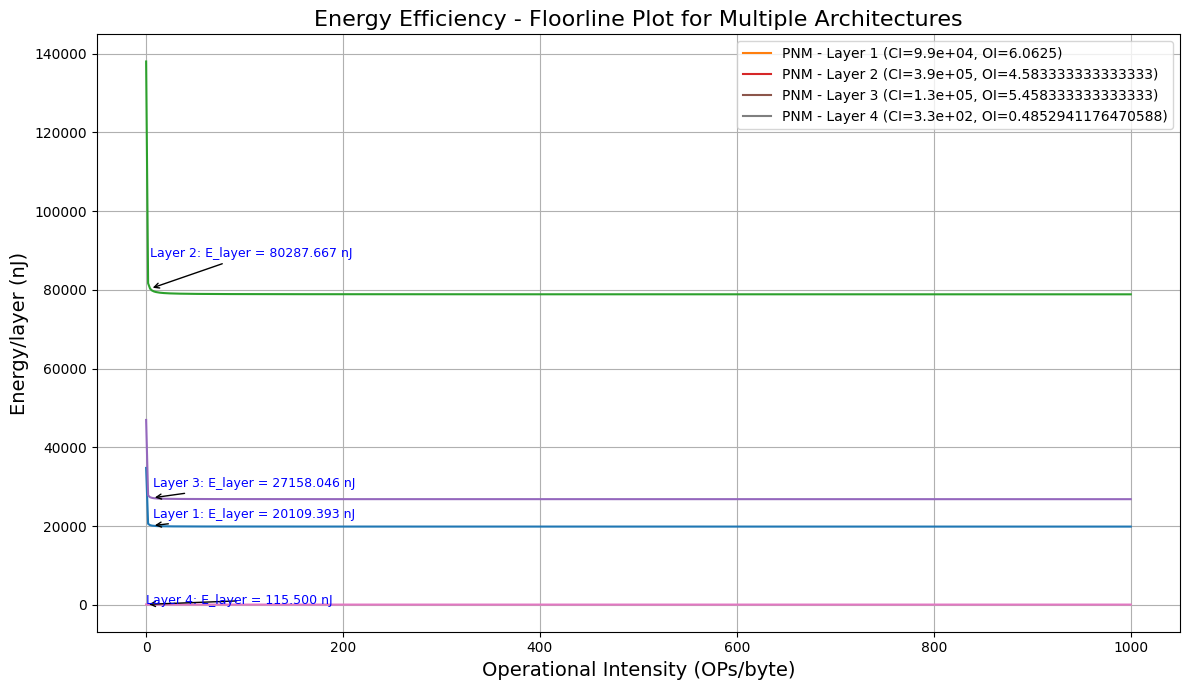

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Architecture Parameters
arch_params = {}

def set_architecture_params(arch_name, E_op_pJ, E_R):
    """
    Sets the parameters for a given architecture.
    E_op_pJ is in picojoules per operation (pJ/op).
    E_R is the energy efficiency ratio of E_m/E_op.
    """
    arch_params[arch_name] = {"E_op_pJ": E_op_pJ, "E_R": E_R}

def workload_inputs(workload_name, CIs, annotation_OIs):
    """
    Takes workload inputs and returns them as a dictionary.
    """
    return {"workload_name": workload_name, "CIs": CIs, "annotation_OIs": annotation_OIs}

def plot_analysis(workload, arch_names):
    """
    Plots the floorline model for multiple architectures and annotates energy per decision (E_dec) with layer numbers.
    Also prints the difference as a percentage between E_dec and E_dec_lower_bound for each layer.
    """
    plt.figure(figsize=(12, 7))
    CIs = workload["CIs"]  # Array of CI values for each layer
    annotation_OIs = workload["annotation_OIs"]  # Array of OI values for each layer

    for arch_name in arch_names:
        if arch_name not in arch_params:
            print(f"Error: '{arch_name}' is not a valid architecture.")
            continue
        print(f"Archicture: {arch_name}")
        # Extract parameters
        params = arch_params[arch_name]
        E_op_pJ = params["E_op_pJ"]
        E_R = params["E_R"]  # E_m/E_op

        # Convert E_op to nanojoules for calculation
        E_op = E_op_pJ / 1000  # Convert pJ to nJ

        # Define operational intensity range
        OI_values = np.linspace(0.1, 1000, 500)  # Adjusted range to cover annotation points

        # Plot the floorline and update the legend with layer numbers
        for i, (ci, oi) in enumerate(zip(CIs, annotation_OIs), start=1):  # Add layer number
            # Calculate energy per decision for the current layer
            E_dec = ci * E_op * (1 + E_R / OI_values)
            E_dec_lower_bound = ci * E_op
            E_dec_annote = ci * E_op * (1 + E_R / oi)
            # Calculate the difference as a percentage
            E_dec_diff_percentage = (E_dec_annote - E_dec_lower_bound) / E_dec_lower_bound * 100

            # Print E_dec_lower_bound and the percentage difference for each layer

            print(f"Layer {i} : E_Difference (E_layer - E_dec_lower_bound) = {E_dec_diff_percentage:.3f}%")

            # Plot the floorline without labeling it yet
            plt.plot(OI_values, E_dec, linewidth=1.5)

            # Annotate the layer-specific operational intensity with layer number
            closest_idx = np.argmin(np.abs(OI_values - oi))
            plt.annotate(f"Layer {i}: E_layer = {E_dec[closest_idx]:.3f} nJ",  # Annotate layer number
                         xy=(OI_values[closest_idx], E_dec[closest_idx]),
                         xytext=(OI_values[closest_idx] * 1.1, E_dec[closest_idx] * 1.1),
                         arrowprops=dict(facecolor='blue', arrowstyle='->'),
                         fontsize=9, color='blue')

            # Update the legend for each layer
            plt.plot([], [], label=f"{arch_name} - Layer {i} (CI={ci:.1e}, OI={oi})")

    # Add labels, title, and legend
    plt.xlabel("Operational Intensity (OPs/byte)", fontsize=14)
    plt.ylabel("Energy/layer (nJ)", fontsize=14)
    plt.title("Energy Efficiency - Floorline Plot for Multiple Architectures", fontsize=16)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Use logarithmic scale for both axes
    #plt.xscale('log')
    #plt.yscale('log')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example Usage
# Set architecture parameters
set_architecture_params("Dig", 2000, 0.8)   # Digital Accelerator (E_op in pJ)
set_architecture_params("PIM", 2, 0.0075) # Processor-In-Memory (E_op in pJ)
set_architecture_params("PNM", 200, 0.075)  # Processor-Near-Memory (E_op in pJ)

# Define workload inputs
workload1 = workload_inputs(
    "AlexNet",
    CIs=np.array([210830400, 895795200, 299040768, 448561152, 299040768, 75497472, 33554432, 8192000]),
    annotation_OIs=np.array([109.8, 257.11, 75.29, 76.9, 75.2, 0.5, 0.5, 0.5])  # Avoid non-positive values here
)

workload2 = workload_inputs(
    "ViT",
    CIs = np.array([99328, 394240, 134144, 330]),
    annotation_OIs = ([6.0625, 4.583333333333333, 5.458333333333333, 0.4852941176470588])

)

# Plot analysis for all architectures in one graph
plot_analysis(workload1, ["Dig"])
plot_analysis(workload1, ["PIM"])
plot_analysis(workload1, ["PNM"])

plot_analysis(workload2, ["Dig"])
plot_analysis(workload2, ["PIM"])
plot_analysis(workload2, ["PNM"])


**Roofline Model**

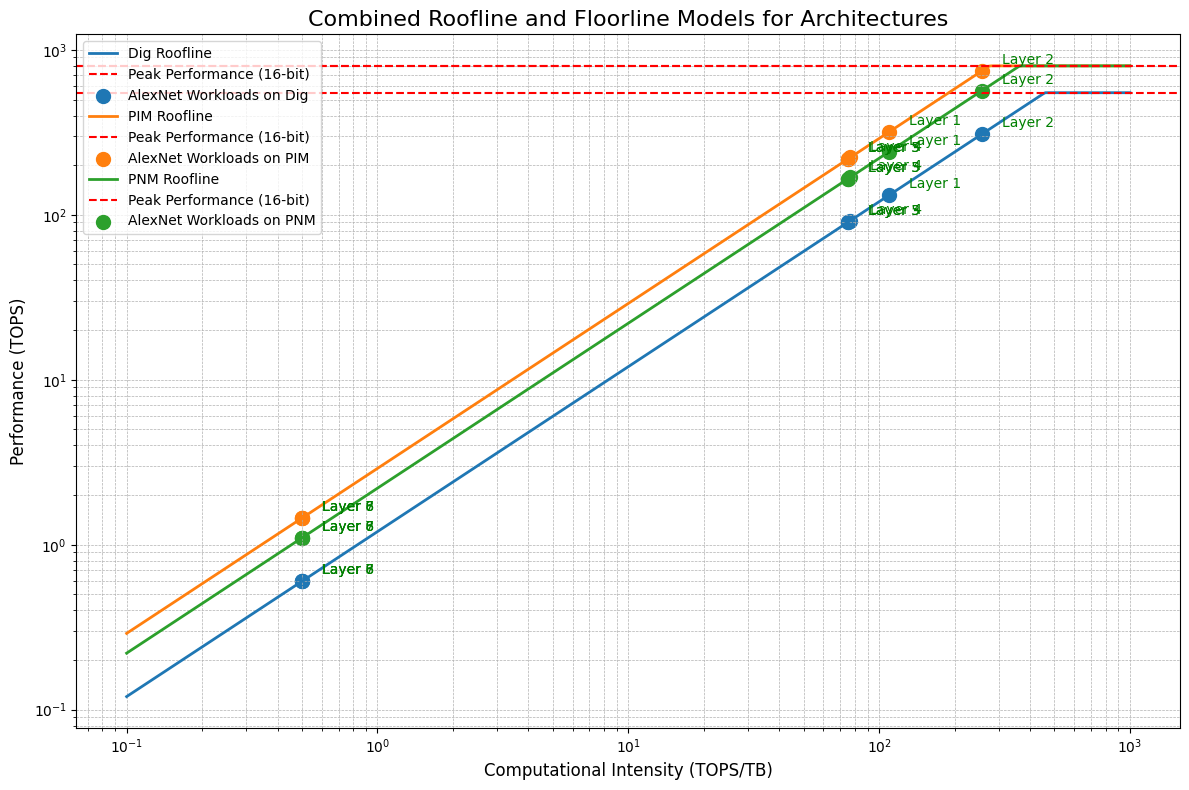

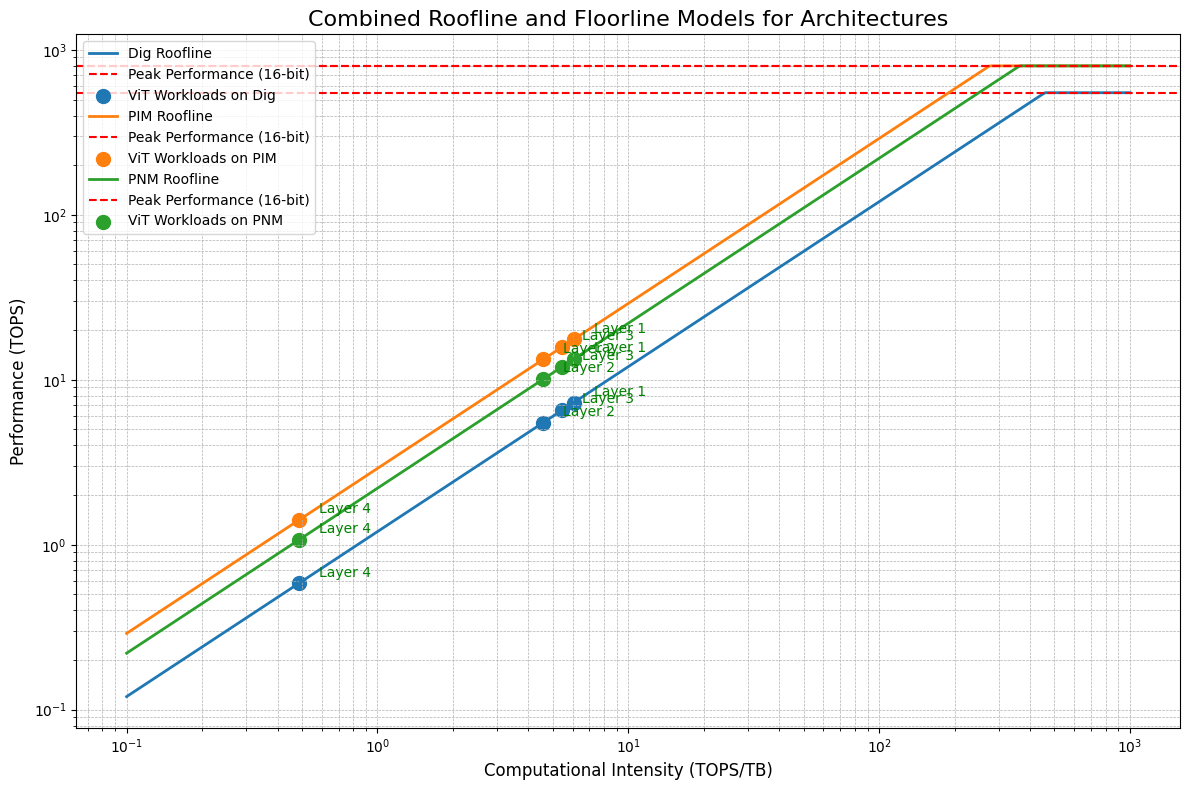

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define architecture parameters
architectures = {}

def set_architecture_params(arch_name, peak_performance_tops, memory_bandwidth_tbps, bit_precision):
    """
    Sets the parameters for a given architecture.
    """
    adjusted_peak_performance = peak_performance_tops * (32 / bit_precision)  # Adjust for bit precision
    adjusted_memory_bandwidth = memory_bandwidth_tbps  # Memory bandwidth remains unchanged for bit precision

    architectures[arch_name] = {
        "peak_performance": adjusted_peak_performance,  # TOPS
        "memory_bandwidth": adjusted_memory_bandwidth,  # TB/s
        "bit_precision": bit_precision
    }

def workload_inputs(workload_name, workload_OIs):
    """
    Takes workload inputs and returns them as a dictionary.
    """
    return {"workload_name": workload_name, "workload_OIs": workload_OIs}

def plot_combined_analysis(workload, arch_names):
    """
    Plots the combined roofline for multiple architectures and a given workload.
    """
    # Define computational intensity range
    OIs = np.logspace(-1, 3, 500)  # TOPS/TB

    plt.figure(figsize=(12, 8))

    for arch_name in arch_names:
        if arch_name not in architectures:
            print(f"Error: '{arch_name}' is not a valid architecture.")
            continue

        # Extract architecture parameters
        arch_params = architectures[arch_name]
        peak_performance = arch_params["peak_performance"]  # Adjusted TOPS
        memory_bandwidth = arch_params["memory_bandwidth"]  # Adjusted TB/s

        # Roofline model equations
        compute_bound = np.full_like( OIs, peak_performance)  # Flat line for compute bound
        memory_bound = OIs * memory_bandwidth  # Diagonal line for memory bound
        performance = np.minimum(compute_bound, memory_bound)  # Effective performance

        # Roofline model (using the operational intensity for the workloads)
        workload_OIs = workload["workload_OIs"]
        workload_performance = [min(i * memory_bandwidth, peak_performance) for i in workload_OIs]

        # Plot Roofline
        plt.loglog(OIs, performance, label=f"{arch_name} Roofline", linewidth=2)
        plt.axhline(peak_performance, color='red', linestyle='--', label=f"Peak Performance ({arch_params['bit_precision']}-bit)")

        # Plot Roofline (based on workload operational intensity)
        plt.scatter(workload_OIs, workload_performance, s=100, label=f"{workload['workload_name']} Workloads on {arch_name}")
        for i, label in enumerate([f"Layer {i+1}" for i in range(len(workload_OIs))]):
            plt.text(workload_OIs[i] * 1.2, workload_performance[i] * 1.1, label, fontsize=10, color='green')

    # Labels and title
    plt.title("Combined Roofline and Floorline Models for Architectures", fontsize=16)
    plt.xlabel("Computational Intensity (TOPS/TB)", fontsize=12)
    plt.ylabel("Performance (TOPS)", fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(fontsize=10, loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage

# Define architecture parameters
'''
Args:
peak_performance_tops  : Give TOPS for 32bit precsion
memory_bandwidth_tbps : Give TB/s
bit_precision         : Give bit precision (32, 16, 8)
'''
set_architecture_params("Dig", peak_performance_tops=275, memory_bandwidth_tbps=1.2, bit_precision=16)  # Digital Accelerator
set_architecture_params("PIM", peak_performance_tops=400, memory_bandwidth_tbps=2.9, bit_precision=16)  # Processor-In-Memory
set_architecture_params("PNM", peak_performance_tops=400, memory_bandwidth_tbps=2.2, bit_precision=16)  # Processor-Near-Memory

# Define workloads
workload1 = workload_inputs("AlexNet", workload_OIs=[109.8, 257.11, 75.29, 76.9, 75.2, 0.5, 0.5, 0.5])
workload2 = workload_inputs("ViT", workload_OIs=[6.0625, 4.5833, 5.45833, 0.4852])
# Plot combined roofline   for AlexNet on Dig, PIM, and PNM
plot_combined_analysis(workload1, ["Dig", "PIM", "PNM"])

# Plot combined roofline   for ViT on Dig, PIM, and PNM
plot_combined_analysis(workload2, ["Dig", "PIM", "PNM"])
